In [1]:
import collections
import os
import json
import logging
import string
import re
import gzip

from scipy.stats import entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import networkx as nx
from Bio import SeqIO

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.codon_bias.graph import load_codon_bias

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")
logger = logging.getLogger(__name__)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

## Tri-nucleotide distributions

In [4]:
method = 'cds'
path = os.path.join(os.getcwd(), f'data/tri_nucleotide_bias_{method}.csv')
tri_bias_df = load_codon_bias(engine, path).set_index('assembly_accession')
tri_bias_df.head()

,species_taxid,in_test_set,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,...,motility,range_salinity,cell_shape,isolation_source,doubling_h,genome_size,gc_content,coding_genes,tRNA_genes,rRNA16S_genes
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCA_000005825.2,79885,False,139927,59650,102178,89728,58512,31554,37763,40331,...,yes,None,bacillus,soil,NaN,4249248.400,37.806,4167.667,77.000,7.000
GCA_000005845.2,562,False,101212,74054,62850,58891,46982,62006,63033,46034,...,yes,non-halophilic,bacillus,host_animal_endotherm,0.338,5146432.283,50.433,4934.661,90.772,7.101
GCA_000006175.2,2188,True,116144,27136,41097,73678,25952,13593,14275,20035,...,yes,None,coccus,sediment_marine,2.255,1936387.600,28.600,1687.000,39.000,2.000
GCA_000006605.1,38289,False,15747,28952,34829,12056,23547,47198,42653,21746,...,no,non-halophilic,bacillus,host_animal_endotherm,NaN,2423189.704,59.738,2109.600,51.250,3.667
GCA_000006685.1,83560,False,35895,15246,22877,20630,14509,7441,7582,12264,...,no,None,bacillus,host_animal_endotherm,NaN,1075065.476,40.120,897.286,37.000,2.000


## Check relation against OGT

We expect a good fit if processing went well

In [5]:
def fit_linear_regression(y_actual, x):
    X = sm.add_constant(x)
    model = sm.OLS(y_actual, X)
    results = model.fit()
    y_fit = results.predict(X)
    return results, y_fit

In [6]:
def plot_true_vs_prediction_per_specie(y_true, y_pred, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(int(np.min(y_true)) - 1, int(np.max(y_true)) + 1)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5, label='Species')
    
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return ax


def compute_and_plot_pattern_against_ogt(y_actual, x, results, ax=None):
    palette = sns.color_palette()

    X = sm.add_constant(x)
    y_fit = results.predict(X)
    
    std, upper, lower = wls_prediction_std(results)
    
    ax = plot_true_vs_prediction_per_specie(y_actual, y_fit, ax=ax)
    
    df_data = [
        [y_actual[i], y_fit[i], std[i]]
        for i in range(len(y_actual))
    ]
    df = pd.DataFrame(df_data, columns=['growth_tmp_actual', 'growth_tmp_prediction', 'growth_tmp_std'])
    
    pred_mean = df[['growth_tmp_actual', 'growth_tmp_prediction']].groupby('growth_tmp_actual').mean()
    std_mean = df[['growth_tmp_actual', 'growth_tmp_std']].groupby('growth_tmp_actual').mean().reset_index()
    x_fill = std_mean['growth_tmp_actual'].values
    x_base = pred_mean['growth_tmp_prediction'].values
    y_fill_1 = x_base - 2 * std_mean['growth_tmp_std'].values
    y_fill_2 = x_base + 2 * std_mean['growth_tmp_std'].values
    ax.fill_between(x_fill, y_fill_1, y_fill_2, alpha=0.2, color=palette[1], label='Uncertainty');

    ax.legend(loc='upper left')
    
    return ax, y_fit


def compute_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [11]:
def fit_model_and_plot(df):
    ratio_columns = [c for c in df.columns if c.endswith('_ratio')]

    x_train = df[~df['in_test_set']][ratio_columns].values
    y_train = df[~df['in_test_set']]['growth_tmp'].values

    x_test = df[df['in_test_set']][ratio_columns].values
    y_test = df[df['in_test_set']]['growth_tmp'].values

    results, y_fit_train = fit_linear_regression(y_train, x_train)

    ax, y_fit_test = compute_and_plot_pattern_against_ogt(y_test, x_test, results)
    
    return (
        compute_mae(y_test, y_fit_test),
        compute_rmse(y_test, y_fit_test), 
        results.rsquared, 
        ax,
    )

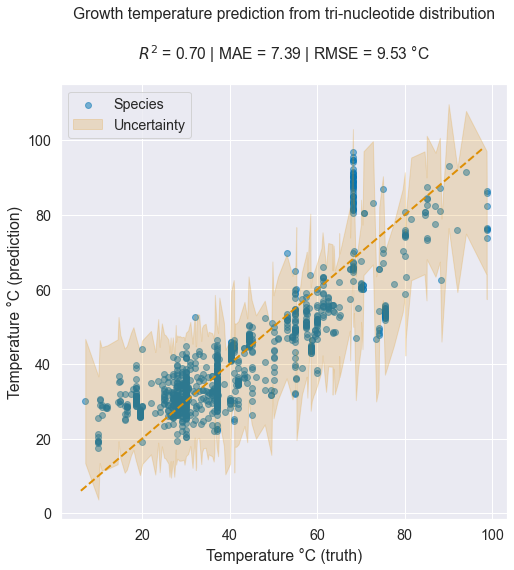

In [14]:
mae, rmse, r2, ax = fit_model_and_plot(tri_bias_df)
ax.set_title((
    f'Growth temperature prediction from tri-nucleotide distribution\n\n'
    f'$R^2$ = {r2:.2f} | MAE = {mae:.2f} | RMSE = {rmse:.2f} °C\n'
));